## 1. Import Python libraries
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_374/img/honey.jpg" alt="honey bee"/></p>
<p>The question at hand is: can a machine identify a bee as a honey bee or a bumble bee? These bees have different <a href="http://bumblebeeconservation.org/about-bees/faqs/honeybees-vs-bumblebees/">behaviors and appearances</a>, but given the variety of backgrounds, positions, and image resolutions it can be a challenge for machines to tell them apart.</p>
<p>Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like <a href="http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/">colony collapse disorder</a> threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_374/img/bumble.jpg" alt="bumble bee">
<em>A bumble bee.</em></p>
<p>This notebook walks through loading and processing images. After loading and processing these images, they will be ready for building models that can automatically detect honeybees and bumblebees.</p>

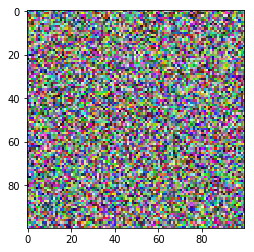

In [1]:
# Used to change filepaths
from pathlib import Path

# We set up matplotlib, pandas, and the display function
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# import numpy to use in this cell
import numpy as np

# import Image from PIL so we can use it later
from PIL import Image

# generate test_data
test_data = np.random.beta(1, 1, (100, 100, 3))

# display the test_data
plt.imshow(test_data)

## 2. Opening images with PIL
<p>Now that we have all of our imports ready, it is time to work with some real images.</p>
<p>Pillow is a very flexible image loading and manipulation library. It works with many different image formats, for example, <code>.png</code>, <code>.jpg</code>, <code>.gif</code> and more. For most image data, one can work with images using the Pillow library (which is imported as <code>PIL</code>).</p>
<p>Now we want to load an image, display it in the notebook, and print out the dimensions of the image. By dimensions, we mean the width of the image and the height of the image. These are measured in pixels. The documentation for <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> in Pillow gives a comprehensive few of what this object can do.</p>

The image size is: (100, 100)


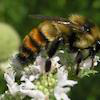

In [2]:
# open the image
img = Image.open('datasets/bee_1.jpg')

# Get the image size
img_size = img.size

print("The image size is: {}".format(img_size))

# Just having the image as the last line in the cell will display it in the notebook
img

## 3. Image manipulation with PIL
<p>Pillow has a number of common image manipulation tasks built into the library. For example, one may want to resize an image so that the file size is smaller. Or, perhaps, convert an image to black-and-white instead of color. Operations that Pillow provides include:</p>
<ul>
<li>resizing</li>
<li>cropping</li>
<li>rotating</li>
<li>flipping</li>
<li>converting to greyscale (or other <a href="https://pillow.readthedocs.io/en/5.1.x/handbook/concepts.html#concept-modes">color modes</a>)</li>
</ul>
<p>Often, these kinds of manipulations are part of the pipeline for turning a small number of images into more images to create training data for machine learning algorithms. This technique is called <a href="http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf">data augmentation</a>, and it is a common technique for image classification.</p>
<p>We'll try a couple of these operations and look at the results.</p>

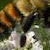

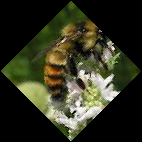

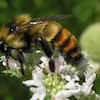

In [3]:
# Crop the image to 25, 25, 75, 75
img_cropped = img.crop((25, 25, 75, 75))
display(img_cropped)

# rotate the image by 45 degrees
img_rotated = img.rotate(45, expand = 25)
display(img_rotated)

# flip the image left to right
img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
display(img_flipped)

## 4. Images as arrays of data
<p>What is an image? So far, PIL has handled loading images and displaying them. However, if we're going to use images as data, we need to understand what that data looks like.</p>
<p>Most image formats have three color <a href="https://en.wikipedia.org/wiki/RGB_color_model">"channels": red, green, and blue</a> (some images also have a fourth channel called "alpha" that controls transparency). For each pixel in an image, there is a value for every channel.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_374/img/AdditiveColor.png" alt="RGB Colors"></p>
<p>The way this is represented as data is as a three-dimensional matrix. The width of the matrix is the width of the image, the height of the matrix is the height of the image, and the depth of the matrix is the number of channels. So, as we saw, the height and width of our image are both 100 pixels. This means that the underlying data is a matrix with the dimensions <code>100x100x3</code>.</p>

Our NumPy array has the shape: (100, 100, 3)


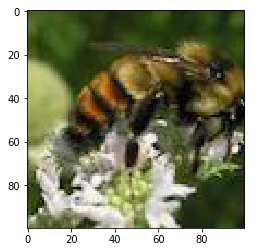

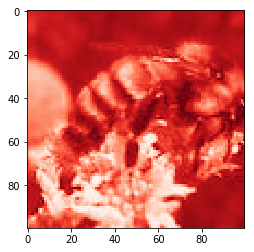

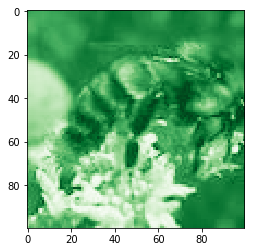

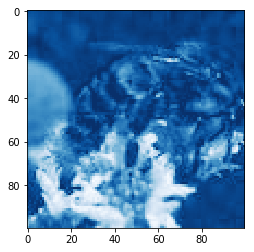

In [4]:
# Turn our image object into a NumPy array
img_data = np.array(img)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow`
plt.imshow(img_data)
plt.show()

# plot the red channel
plt.imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
plt.show()

# plot the green channel
plt.imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
plt.show()

# plot the blue channel
plt.imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
plt.show()

## 5. Explore the color channels
<p>Color channels can help provide more information about an image. A picture of the ocean will be more blue, whereas a picture of a field will be more green. This kind of information can be useful when building models or examining the differences between images.</p>
<p>We'll look at the <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">kernel density estimate</a> for each of the color channels on the same plot so that we can understand how they differ.</p>
<p>When we make this plot, we'll see that a shape that appears further to the right means more of that color, whereas further to the left means less of that color.</p>

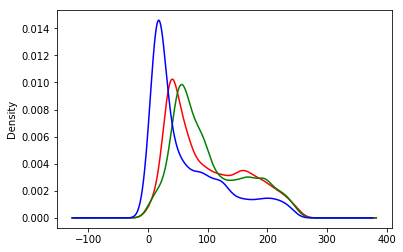

In [5]:
def plot_kde(channel, color):
    """ Plots a kernel density estimate for the given data.
        
        `channel` must be a 2d array
        `color` must be a color string, e.g. 'r', 'g', or 'b'
    """
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# create the list of channels
channels = ['r', 'g', 'b']
    
def plot_rgb(image_data):
    # use enumerate to loop over colors and indexes
    for ix, color in enumerate(channels):
        plot_kde(image_data[:, :, ix], color)
    plt.show()
    
plot_rgb(img_data)

## 6. Honey bees and bumble bees (i)
<p>Now we'll look at two different images and some of the differences between them. The first image is of a honey bee, and the second image is of a bumble bee.</p>
<p>First, let's look at the honey bee.</p>

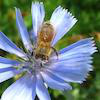

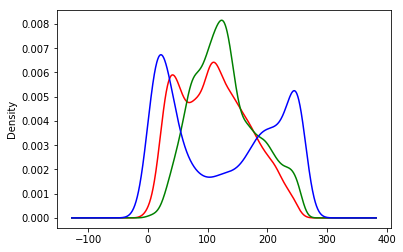

In [6]:
# load bee_12.jpg as honey
honey = Image.open('datasets/bee_12.jpg')

# display the honey bee image
display(honey)

# NumPy array of the honey bee image data
honey_data = np.array(honey)

# plot the rgb densities for the honey bee image
plot_rgb(honey_data)

## 7. Honey bees and bumble bees (ii)
<p>Now let's look at the bumble bee.</p>
<p>When one compares these images, it is clear how different the colors are. The honey bee image above, with a blue flower, has a strong peak on the right-hand side of the blue channel. The bumble bee image, which has a lot of yellow for the bee and the background, has almost perfect overlap between the red and green channels (which together make yellow).</p>

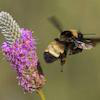

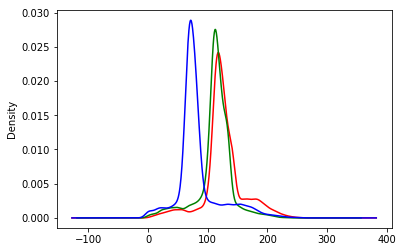

In [7]:
# load bee_3.jpg as bumble
bumble = Image.open('datasets/bee_3.jpg')

# display the bumble bee image
display(bumble)

# NumPy array of the bumble bee image data
bumble_data = np.array(bumble)

# plot the rgb densities for the bumble bee image
plot_rgb(bumble_data)

## 8. Simplify, simplify, simplify
<p>While sometimes color information is useful, other times it can be distracting. In this examples where we are looking at bees, the bees themselves are very similar colors. On the other hand, the bees are often on top of different color flowers. We know that the colors of the flowers may be distracting from separating honey bees from bumble bees, so let's convert these images to <a href="https://en.wikipedia.org/wiki/Grayscale">black-and-white, or "grayscale."</a></p>
<p>Grayscale is just one of the <a href="https://pillow.readthedocs.io/en/5.0.0/handbook/concepts.html#modes">modes that Pillow supports</a>. Switching between modes is done with the <code>.convert()</code> method, which is passed a string for the new mode.</p>
<p>Because we change the number of color "channels," the shape of our array changes with this change. It also will be interesting to look at how the KDE of the grayscale version compares to the RGB version above.</p>

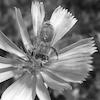

Our NumPy array has the shape: (100, 100)


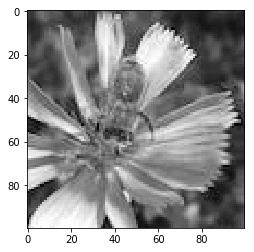

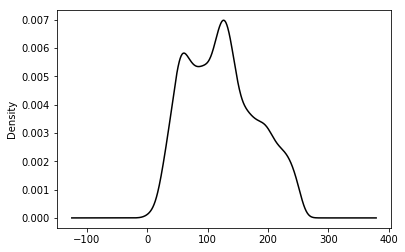

In [8]:
# convert honey to grayscale
honey_bw = honey.convert(mode="L")
display(honey_bw)

# convert the image to a NumPy array
honey_bw_arr = np.array(honey_bw)

# get the shape of the resulting array
honey_bw_arr_shape = honey_bw_arr.shape
print("Our NumPy array has the shape: {}".format(honey_bw_arr_shape))

# plot the array using matplotlib
plt.imshow(honey_bw_arr, cmap=plt.cm.gray)
plt.show()

# plot the kde of the new black and white array
plot_kde(honey_bw_arr, 'k')

## 9. Save your work!
<p>We've been talking this whole time about making changes to images and the manipulations that might be useful as part of a machine learning pipeline. To use these images in the future, we'll have to save our work after we've made changes.</p>
<p>Now, we'll make a couple changes to the <code>Image</code> object from Pillow and save that. We'll flip the image left-to-right, just as we did with the color version. Then, we'll change the NumPy version of the data by clipping it. Using the <code>np.maximum</code> function, we can take any number in the array smaller than <code>100</code> and replace it with <code>100</code>. Because this reduces the range of values, it will increase the <a href="https://en.wikipedia.org/wiki/Contrast_(vision)">contrast of the image</a>. We'll then convert that back to an <code>Image</code> and save the result.</p>

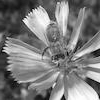

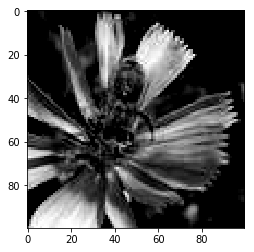

In [9]:
# flip the image left-right with transpose
honey_bw_flip = honey_bw.transpose(Image.FLIP_LEFT_RIGHT)

# show the flipped image
display(honey_bw_flip)

# save the flipped image
honey_bw_flip.save("saved_images/bw_flipped.jpg")

# create higher contrast by reducing range
honey_hc_arr = np.maximum(honey_bw_arr, 100)

# show the higher contrast version
plt.imshow(honey_hc_arr, cmap=plt.cm.gray)

# convert the NumPy array of high contrast to an Image
honey_bw_hc = Image.fromarray(honey_hc_arr)

# save the high contrast version
honey_bw_hc.save("saved_images/bw_hc.jpg")

## 10. Make a pipeline
<p>Now it's time to create an image processing pipeline. We have all the tools in our toolbox to load images, transform them, and save the results.</p>
<p>In this pipeline we will do the following:</p>
<ul>
<li>Load the image with <code>Image.open</code> and create paths to save our images to</li>
<li>Convert the image to grayscale</li>
<li>Save the grayscale image</li>
<li>Rotate, crop, and zoom in on the image and save the new image</li>
</ul>

In [10]:
image_paths = ['datasets/bee_1.jpg', 'datasets/bee_12.jpg', 'datasets/bee_2.jpg', 'datasets/bee_3.jpg']

def process_image(path):
    img = Image.open(path)

    # create paths to save files to
    bw_path = "saved_images/bw_{}.jpg".format(path.stem)
    rcz_path = "saved_images/rcz_{}.jpg".format(path.stem)

    print("Creating grayscale version of {} and saving to {}.".format(path, bw_path))
    bw = img.convert(mode='L')
    bw.save(bw_path)

    print("Creating rotated, cropped, and zoomed version of {} and saving to {}.".format(path, rcz_path))
    rcz = img.rotate(45).crop((25, 25, 75, 75)).resize((100, 100))
    rcz.save(rcz_path)

# for loop over image paths
for img_path in image_paths:
    process_image(Path(img_path))

Creating grayscale version of datasets\bee_1.jpg and saving to saved_images/bw_bee_1.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_1.jpg and saving to saved_images/rcz_bee_1.jpg.
Creating grayscale version of datasets\bee_12.jpg and saving to saved_images/bw_bee_12.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_12.jpg and saving to saved_images/rcz_bee_12.jpg.
Creating grayscale version of datasets\bee_2.jpg and saving to saved_images/bw_bee_2.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_2.jpg and saving to saved_images/rcz_bee_2.jpg.
Creating grayscale version of datasets\bee_3.jpg and saving to saved_images/bw_bee_3.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_3.jpg and saving to saved_images/rcz_bee_3.jpg.
